In [52]:
import json, os, math, random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
TRAINING = '/Users/user/data/research/proton-deuteron/ssvd/handpicked_d.pkl'
CANDIDATES = '/Users/user/data/research/proton-deuteron/ssvd/deuteron_candidates_clean.pkl'

In [3]:
IMG_H, IMG_W = 64, 96

In [38]:
class CandidateDS(Dataset):
    def __init__(self, df, global_max_adc):
        self.df = df.reset_index(drop=True)
        self.gmax = float(global_max_adc)

    def __len__(self):
        return len(self.df)
    
    def _to_fixed(self, img):
        h, w, = img.shape
        out = np.zeros((IMG_H, IMG_W), dtype=np.float32)
        h0 = min(h, IMG_H)
        w0 = min(w, IMG_W)
        out[:h0, :w0] = img[:h0, :w0]
        return out
    
    def __getitem__(self, i):
        arr = np.asarray(self.df.loc[i, 'image_intensity'], dtype=np.float32)
        x = self._to_fixed(arr)

        ch0 = x / (self.gmax + 1e-6)
        
        mu, sd = float(x.mean()), float(x.std())
        if sd < 1e-6: sd = 1e-6
        ch1 = (x - mu) / sd

        x2 = np.stack([ch0, ch1], axis=0)                                           # (2, H, W)

        return torch.from_numpy(x2), i

In [98]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print('Device:', device)

global_max_adc = 2342.0                                                         # or try 1713.0 from the training data

print('Global max ADC:', global_max_adc)

print('Loading candidates:', CANDIDATES)
df = pd.read_pickle(CANDIDATES)
n = len(df)
print('Rows:', n)

train = pd.read_pickle(TRAINING)

ds = CandidateDS(df, global_max_adc)

Device: mps
Global max ADC: 2342.0
Loading candidates: /Users/user/data/research/proton-deuteron/ssvd/deuteron_candidates_clean.pkl
Rows: 4544


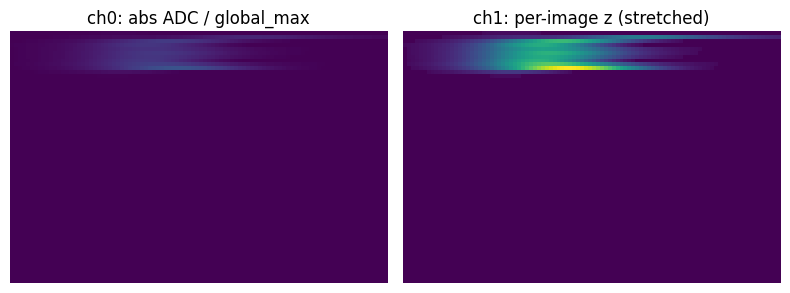

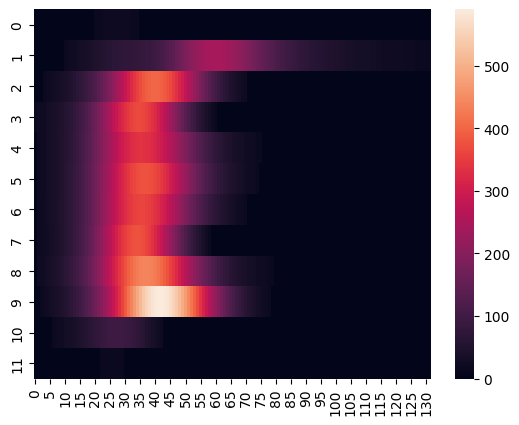

In [78]:
i = random.randint(0, len(ds))  
x = ds[i]                 # shape: (2, H, W), on CPU
ch0 = x[0][0].numpy()
ch1 = x[0][1].numpy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Channel 0: scaled absolute ADC
axs[0].imshow(ch0, vmin=0.0, vmax=1.0)
axs[0].set_title("ch0: abs ADC / global_max")
axs[0].axis("off")

# Channel 1: z-score (stretch to [0,1] for display only)
z = ch1
z_disp = (z - z.min()) / (z.max() - z.min() + 1e-6)
axs[1].imshow(z_disp)
axs[1].set_title("ch1: per-image z (stretched)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

sns.heatmap(df['image_intensity'].iloc[i])
plt.show()

In [85]:
def pad_image(image, min_x, max_x, min_y, max_y, target_wh=(3072, 240)):
    """
    Place a 2D image block into a zero canvas of size (height=target_wh[1], width=target_wh[0]).

    image: 2D np.ndarray, shape (h, w)
    min_x, max_x: x-bounds (columns) in the target (0..target_w-1)
    min_y, max_y: y-bounds (rows) in the target (0..target_h-1)
    target_wh: (target_width, target_height)
    """
    target_w, target_h = target_wh
    canvas = np.zeros((target_h, target_w), dtype=image.dtype)

    span_x = max_x - min_x + 1
    span_y = max_y - min_y + 1

    h, w = image.shape
    if (h != span_y) or (w != span_x):
        if abs(h - span_y) > 2 or abs(w - span_x) > 2:
            print(f"Image shape ({h}, {w}) != span ({span_y}, {span_x})")

    # Clip placement to canvas
    y0 = max(0, min_y)
    y1 = min(target_h, min_y + h)
    x0 = max(0, min_x)
    x1 = min(target_w, min_x + w)

    # Corresponding source window
    img_y0 = max(0, -min_y)
    img_x0 = max(0, -min_x)
    img_y1 = img_y0 + (y1 - y0)
    img_x1 = img_x0 + (x1 - x0)

    if y0 < y1 and x0 < x1:  # only write if overlap is non-empty
        canvas[y0:y1, x0:x1] = image[img_y0:img_y1, img_x0:img_x1]

    return canvas


In [ ]:
images = [] # all data

for idx, row in df.iterrows():
    
    padded = pad_image(
        row['image_intensity'],
        row['bbox_min_col'],
        row['bbox_max_col'],
        row['bbox_min_row'],
        row['bbox_max_row']
    )
    images.append(padded)

images = np.array(images)

154 944 25 196
608 1051 32 138
1311 1509 36 183
1202 1380 17 104
840 1189 30 66
573 1051 29 142
1223 1363 30 96
899 1120 21 89
924 1355 30 146
1213 1332 17 41
977 1314 20 123
1184 1350 20 46
1144 1311 22 72
82 963 22 194
1493 1683 32 65
1658 1785 19 53
989 1382 30 93
624 1038 25 159
825 990 19 114
1168 1319 27 48
839 1149 25 156
1119 1409 21 104
1108 1240 19 47
1263 1776 33 211
1638 1759 17 43
1062 1307 22 87
740 1133 33 160
871 1113 28 70
910 1092 25 42
835 1078 32 144
1293 1499 22 77
388 1058 20 94
1196 1466 25 82
848 1237 34 128
652 1091 26 108
929 1084 32 129
1250 1456 22 107
910 1155 20 47
869 1046 21 84
171 917 21 154
1055 1357 27 77
1320 1685 30 73
934 1104 33 108
1362 1530 25 57
1220 1511 32 172
1435 1572 27 78
1534 1819 34 146
592 950 34 108
1231 1489 24 53
981 1271 14 31
1582 1747 24 55
297 806 31 58
798 1044 19 96
1337 1723 33 212
598 1034 32 158
1116 1310 27 76
729 1122 27 165
914 1124 18 59
944 1195 32 111
976 1132 16 40
1493 1636 24 63
1219 1329 17 45
1205 1467 25 87
876 

<Axes: >

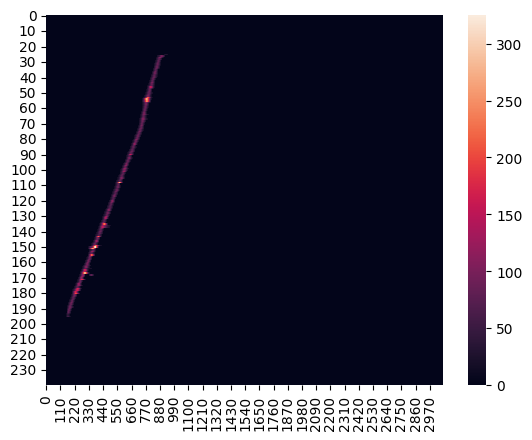

In [137]:
sns.heatmap(images[0])

In [99]:
training = [] # all data

for idx, row in train.iterrows():
    
    padded = pad_image(
        row['image_intensity'],
        row['bbox_min_col'],
        row['bbox_max_col'],
        row['bbox_min_row'],
        row['bbox_max_row']
    )
    training.append(padded)

training = np.array(training)

In [241]:
3072/4, 240/4

(768.0, 60.0)

In [ ]:
from scipy.ndimage import zoom

def downsample_image(image, target_shape=(512, 40)):
    scale_y = target_shape[1] / image.shape[0]
    scale_x = target_shape[0] / image.shape[1]
    return zoom(image, (scale_y, scale_x), order=1)  # order=1 for bilinear interpolation

# Example usage
downsampled_training = np.array([downsample_image(img, target_shape=(1024, 80)) for img in training])
downsampled_inference = np.array([downsample_image(img, target_shape=(1024, 80)) for img in images])


<Axes: >

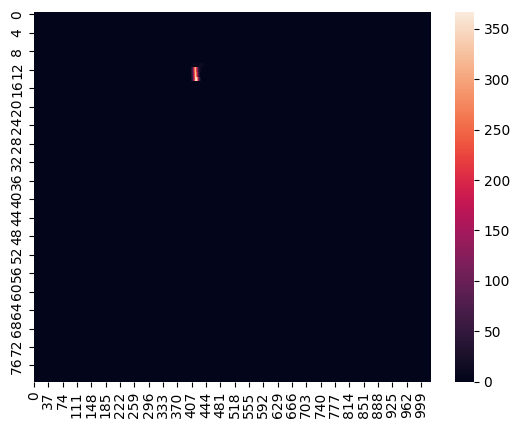

In [178]:
import random 
i= random.randint(0, len(training))
sns.heatmap(downsampled_training[i])

<Axes: >

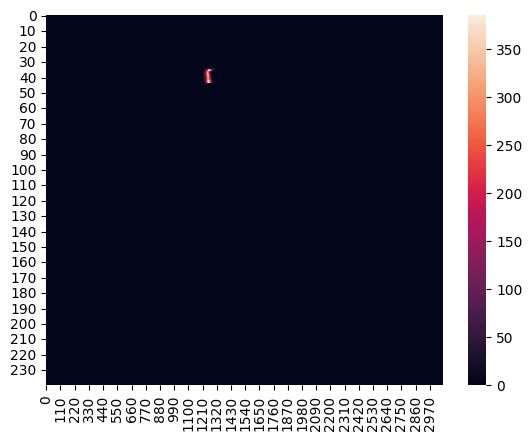

In [179]:
sns.heatmap(training[i])

<Axes: >

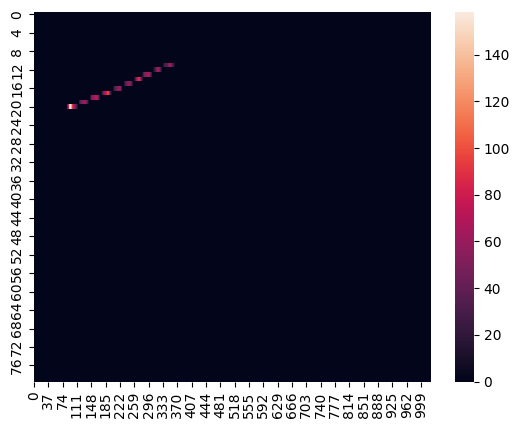

In [240]:
import random 
i= random.randint(0, len(training))
sns.heatmap(downsampled_inference[i])

In [ ]:
def pad_image(image, min_x, max_x, min_y, max_y, target_wh=(3072, 240)):
    target_w, target_h = target_wh
    canvas = np.zeros((target_h, target_w), dtype=image.dtype)

    h, w = image.shape

    y0 = max(0, min_y)
    y1 = min(target_h, min_y + h)
    x0 = max(0, min_x)
    x1 = min(target_w, min_x + w)

    img_y0 = max(0, -min_y)
    img_x0 = max(0, -min_x)
    img_y1 = img_y0 + (y1 - y0)
    img_x1 = img_x0 + (x1 - x0)

    if y0 < y1 and x0 < x1:
        canvas[y0:y1, x0:x1] = image[img_y0:img_y1, img_x0:img_x1]
    
    return canvas

from scipy.ndimage import zoom

def downsample_image(image, target_shape=(512, 40)):
    scale_y = target_shape[1] / image.shape[0]
    scale_x = target_shape[0] / image.shape[1]
    return zoom(image, (scale_y, scale_x), order=1) 

In [ ]:
class DeutTrain(Dataset):
    def __init__(self, df, global_max_adc):
        self.df = df.reset_index(drop=True)
        self.gmax = float(global_max_adc)

    def __len__(self):
        return len(self.df)
    
    def _to_fixed(self, img):
        # TODO: NEED TO PRESERVE A SENSE OF LENGTH PROPERLY
        h, w, = img.shape
        out = np.zeros((IMG_H, IMG_W), dtype=np.float32)
        h0 = min(h, IMG_H)
        w0 = min(w, IMG_W)
        out[:h0, :w0] = img[:h0, :w0]
        return out
    
    def __getitem__(self, i):
        row = self.df.loc[i]

        img = np.asarray(row['image_intensity'], dtype=np.float32)
        
        x = pad_image(
            img,
            int(row['bbox_min_col']),
            int(row['bbox_max_col']),
            int(row['bbox_min_row']),
            int(row['bbox_max_row']),
        )
        
        x = downsample_image(x, target_shape=(IMG_W, IMG_H))

        ch0 = x / (self.gmax + 1e-6)
        
        mu, sd = float(x.mean()), float(x.std())
        if sd < 1e-6: sd = 1e-6
        ch1 = (x - mu) / sd

        x2 = np.stack([ch0, ch1], axis=0)                                           # (2, H, W)

        return torch.from_numpy(x2)